In [2]:
from typing import List
import os
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_community.tools.openweathermap import OpenWeatherMapQueryRun
from langchain_core.utils.function_calling import convert_to_openai_function
from langgraph.graph import Graph
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
import requests

c:\Users\tnguy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = os.environ.get("OPENWEATHERMAP_API_KEY")
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from datetime import date, datetime
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant. "
            "Use your tool first"
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

In [6]:
import requests

@tool
def get_joke() -> str:
    """
    Fetch a random joke from the JokeAPI.

    Returns:
        str: The fetched joke as a string. If no joke is available, returns 'No joke available'.
    """
    response = requests.get("https://v2.jokeapi.dev/joke/Any?type=single")
    joke = response.json().get('joke', 'No joke available')
    return joke

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0, streaming=True)
#llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY, temperature=0, streaming=True)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant. "
            " Use the provided tools to search weather , and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
tools = [
    OpenWeatherMapQueryRun(),
    #get_joke()
]
functions = [convert_to_openai_function(t) for t in tools]
model = llm.bind_functions(functions=functions)
#assitant = primary_assistant_prompt | llm.bind_tools(tools)

In [8]:
def function_1(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}



In [9]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

def function_2(state):
    messages = state['messages']
    last_message = messages[-1]  # this has the query we need to send to the tool provided by the agent

    # Parse the tool input from the function call
    parsed_tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"])

    # Print the parsed tool input for debugging
    print("Parsed Tool Input:", parsed_tool_input)

    # Ensure the key exists in the parsed tool input
    if 'location' in parsed_tool_input:
        tool_input_value = parsed_tool_input['location']
    else:
        raise KeyError("The key 'location' does not exist in the tool input.")

    # Construct a ToolInvocation from the function call and pass in the tool name and the expected str input for OpenWeatherMap tool
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=tool_input_value,
    )

    # Call the tool_executor and get back a response
    response = tool_executor.invoke(action)

    # Use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # Return a list, because this will get added to the existing list
    return {"messages": [function_message]}


In [10]:
def where_to_go(state):
    messages = state['messages']
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "continue"
    elif "joke" in last_message.content.lower():
        return "joke"
    else:
        return "end"

In [12]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)


workflow = Graph()
workflow.add_node("agent", function_1)
workflow.add_node("tool", function_2)

# The conditional edge requires the following info below.
# First, we define the start node. We use `agent`.
# This means these are the edges taken after the `agent` node is called.
# Next, we pass in the function that will determine which node is called next, in our case where_to_go().

workflow.add_conditional_edges("agent", where_to_go,{   # Based on the return from where_to_go
                                                        # If return is "continue" then we call the tool node.
                                                        "continue": "tool",
                                                        # Otherwise we finish. END is a special node marking that the graph should finish.
                                                        "end": END
                                                    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that if `tool` is called, then it has to call the 'agent' next. 
workflow.add_edge('tool', 'agent')


# Basically, agent node has the option to call a tool node based on a condition, 
# whereas tool node must call the agent in all cases based on this setup.

workflow.set_entry_point("agent")


app = workflow.compile()

In [78]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="Give me a joke")]}
app.invoke(inputs)

{'messages': [AIMessage(content="Why don't scientists trust atoms?\n\nBecause they make up everything!", response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b0abffe81'}, id='run-5431d037-c382-4e26-9e94-3ae5045380b8-0')]}

In [79]:
#inputs = {"messages": [HumanMessage(content="what is the temperature of Oakland")]}
inputs = {"messages": [HumanMessage(content="Give me a info about the weather in the city that olympic 2024 is live")]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"location":"Paris,FR"}', 'name': 'open_weather_map'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b0abffe81'}, id='run-e1ef7c13-b2f0-4d29-b940-80448fa0c0b8-0')]}

---

Parsed Tool Input: {'location': 'Paris,FR'}
Output from node 'tool':
---
{'messages': [FunctionMessage(content='In Paris,FR, the current weather is as follows:\nDetailed status: clear sky\nWind speed: 1.54 m/s, direction: 70°\nHumidity: 88%\nTemperature: \n  - Current: 14.68°C\n  - High: 15.88°C\n  - Low: 13.26°C\n  - Feels like: 14.5°C\nRain: {}\nHeat index: None\nCloud cover: 0%', name='open_weather_map')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='The current weather in Paris, France is clear with a temperature of 14.68°C. Here are the details:\n\n- **Detailed Status:** Clear sky\n- **Wind Speed:** 1

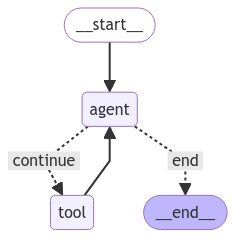

In [80]:
from IPython.display import Image, display
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))